In [1]:
! nvidia-smi

Tue Dec 13 15:03:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   22C    P8     4W / 350W |      2MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [2]:
import os, random

# Makes sure the script has acess to one GPU
cuda_device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(cuda_device)

import torch
torch.cuda.is_available()

True

In [28]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm  

from scipy.stats import spearmanr

import torch 
import torch.nn as nn 

import transformers 
from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

In [4]:
def set_seed(seed: int, set_random=True):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    if set_random:
        random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
    
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [6]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed 
seed = 31
set_seed(seed)

In [7]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer                      # the Tokenizer model
        self.data      = dataframe                      # the full dataset
        self.report    = dataframe.report               # the text data (i.e., the reports)
        self.targets   = self.data.Report_as_Multilabel # labels' list to classify
        self.max_len   = max_length                     # max length fro truncation

    def __len__(self):
        return len(self.report)

    def __getitem__(self, index):
        report = str(self.report[index])
        report = " ".join(report.split())

        inputs = self.tokenizer.encode_plus(
            report,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }
    
# Creating the dataset and dataloader for the neural network
def get_Fold(k_seed, train_size = 0.8):
    
    train_dataset = final_df_dataset.sample(frac=train_size, random_state=k_seed)
    test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    test_params = {
        'batch_size': valid_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader  = DataLoader(testing_set, **test_params)
    
    return training_loader, testing_loader

# Creating the dataset and dataloader for the neural network
def get_collection_Fold(collection):
    
    train_dataset = final_df_dataset[~final_df_dataset["collection"].isin([collection])]
    test_dataset  = final_df_dataset[final_df_dataset["collection"].isin([collection])]

    train_dataset = train_dataset.reset_index(drop=True)
    test_dataset  = test_dataset.reset_index(drop=True)

    training_set = CustomDataset(train_dataset, tokenizer, max_length)
    testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

    train_params = {
        'batch_size': train_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    test_params = {
        'batch_size': valid_batch_size,
        'shuffle': True,
        'num_workers': 0
    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader  = DataLoader(testing_set, **test_params)
    
    return training_loader, testing_loader

# Creating the customized model, by adding a drop out and a dense layer on top of 
# the BERT (or any other) model, to get the final output. 
class BERTClass(torch.nn.Module):
    def __init__(self, model_name, n_classes, freeze_BERT=False, layer=-1, idx=0):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained(model_name)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, n_classes)
        self.layer = layer
        self.idx   = idx  
        # Froze the weight of model aside of the classifier
        if froze_model_layer:
            print("Freezing the layer of BERT model")
            for name, param in self.l1.named_parameters():
                if "classifier" not in name:
                    param.requires_grad = False
                    
    def forward(self, ids, mask, token_type_ids):
        output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_1 = output_1.last_hidden_state[:, -1, :]
        output_2 = self.l2(output_1)
        output   = self.l3(output_2)
        return output

# Loss function 
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Training regime
def train(epoch, model, training_loader, optimizer, return_losses=False):
    Losses = []
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            Losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if return_losses:
        return Losses
    
# Validate (test) the model
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

Single Fold
- [Dataset and Model Setup](#setup)
- [Training and Evaluation](#train_eval)
- [Analysis](#analysis)

[K-Fold Experiment](#kfold)

[Ablation Experiment](#ablation)

---------
## Loading data<a id='intro'></a>

In [9]:
# Load the dataset in CSV
dream_records = pd.read_csv(
    "Reports_with_Dreamer_and_General_Emotions_PCAxy_tSNExy_CllKmC_Gnd_KmC_2WSA_6WSA.csv"
)

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}

COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline",
]

Convert each set of labels/Emotion is a list signaling the prsence/absence of each emotion.

In [ ]:
emotions_list = list(Coding_emotions.keys())
emotions_list.remove("Missing")

EMOTION_SET = "General Emotions"

print("Collect data. Emotion Set : {}".format(EMOTION_SET))
report_as_multi_label = []
for rprt_emtn_lst in tqdm(dream_records[EMOTION_SET]):
    lcl_report_as_multi_label = []
    for emotion_acronim in emotions_list:
        if emotion_acronim in rprt_emtn_lst:
            lcl_report_as_multi_label.append(1)
        else:
            lcl_report_as_multi_label.append(0)
    report_as_multi_label.append(lcl_report_as_multi_label)

dream_records["Report_as_Multilabel"] = report_as_multi_label

final_df_dataset = dream_records[~dream_records["# {}".format(EMOTION_SET)].isin([0])].reset_index(drop=True)

In [ ]:
final_df_dataset = final_df_dataset[["report", "Report_as_Multilabel", "collection"]]

## Single Fold
### Dataset and Model Setup<a id='setup'></a>

In [ ]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 8 # always use power of 2!
valid_batch_size  = 4
learning_rate     = 1e-05
froze_model_layer = False 

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.8
train_dataset = final_df_dataset.sample(frac=train_size, random_state=seed)
test_dataset  = final_df_dataset.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset:  {}".format(final_df_dataset.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset:  {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, max_length)
testing_set  = CustomDataset(test_dataset, tokenizer, max_length)

In [ ]:
train_params = {
    'batch_size': train_batch_size,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': valid_batch_size,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader  = DataLoader(testing_set, **test_params)

In [ ]:
model_tuned = BERTClass(
    model_name=model_name, 
    n_classes=len(emotions_list), 
    freeze_BERT=False
)

model_tuned.to(device)

optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
)

### Training and Evaluation<a id='train_eval'></a>
Training a model on a single split 

In [ ]:
for ep in range(epochs):
    train(ep, model_tuned, training_loader, optimizer_tuned)

In [ ]:
outputs, targets = validation(model_tuned, testing_loader)
outputs = np.array(outputs) >= 0.5

In [ ]:
pd.DataFrame.from_dict(
    metrics.classification_report(
        targets,
        outputs,
        target_names=emotions_list,
        zero_division=0,
        output_dict=True,
    ), 
    orient='index',
).round(2)

### Analysis<a id='analysis'></a>

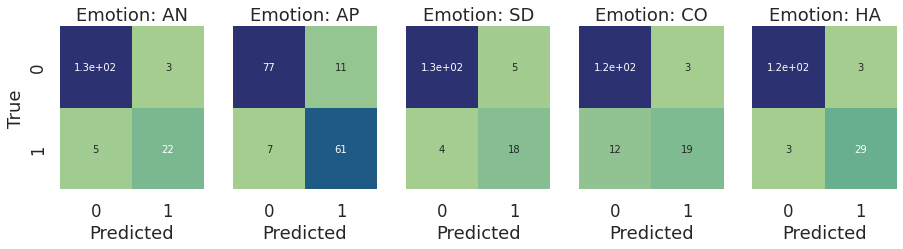

In [ ]:
emotions_CM = metrics.multilabel_confusion_matrix(
    targets,
    outputs,
)

plt.figure(figsize=(15, 3))
for cnt, cm in enumerate(emotions_CM): 
    
    plt.subplot(1,5,cnt+1) 
    g = sns.heatmap(cm, cmap="crest", cbar=False, annot=True)
    plt.title("Emotion: {}".format(emotions_list[cnt]))
    plt.xlabel("Predicted")
    if cnt == 0:
        plt.ylabel("True")
    else:
        g.set_yticklabels(["", ""])
        
plt.show()

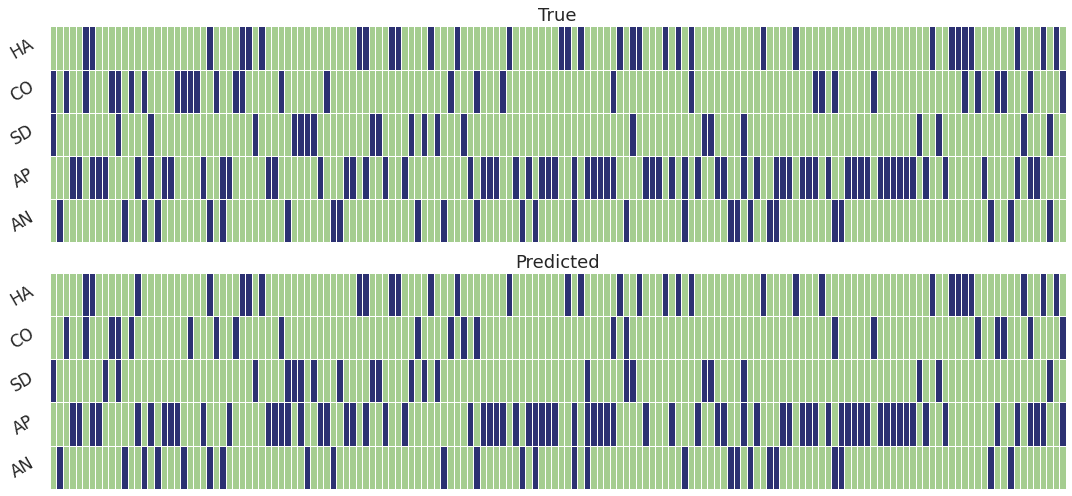

In [ ]:
plt.figure(figsize=(15, 7))
for cnt, [name, data] in enumerate({"True":targets, "Predicted":outputs}.items()): 
    
    rot_data = np.rot90(data)
    _bar = True if cnt != 0 else False
    plt.subplot(2,1,cnt+1)
    g = sns.heatmap(
            rot_data, 
            cmap="crest",
            linewidth=.8,
            xticklabels=False, 
            yticklabels=list(reversed(emotions_list)),
            cbar=False,
    )
    g.set_yticklabels(g.get_yticklabels(), rotation=30)        
    plt.title("{}".format(name))
    
plt.tight_layout()
plt.show()

In the "DNA" plot above, each column represents a single Dream Report, while each row reflects a specific emotion. The rectangles represent the labels of each report. Blue indicates the presence of that label (i.e., the report was labelled as containing that emotion), while green indicates its absence.

## K-Fold Cross Validation<a id='kfold'></a>
In previous experiment, we observed a jump in perfprmance after 5 epochs. The K-Fold experimetn should allow us to understand how stable such jump is, acorss different random samples of the dataset.

In [ ]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 2 # always use power of 2!
valid_batch_size  = 2
learning_rate     = 1e-05
froze_model_layer = False 
K_fold            = 5

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')

A100-SXM4-40GB
1


In [ ]:
SCORES, LOSSES, DATAFRAMES = [], [], []
for fold in range(K_fold):

    print('Fold {}'.format(fold + 1))
    rand_int = random.randint(0, 10000)
    train_loader, testing_loader = get_Fold(rand_int, train_size = 0.8)

    # makes sure the seed for model init is the same
    set_seed(seed, set_random=False) 
    
    # Set Model and Optmizer (for each fold)
    model_tuned = BERTClass(
        model_name=model_name, 
        n_classes=len(emotions_list), 
        freeze_BERT=False
    )

    optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
    ) 
    
    model_tuned.to(cuda0)
    
    #Train and test the model
    for ep in range(epochs):
        train_losses = train(
            ep, 
            model_tuned, 
            train_loader, 
            optimizer_tuned, 
            return_losses=True,
        )
        LOSSES.append(train_losses)
    
    print("Testing the Model")
    outputs, targets = validation(model_tuned, testing_loader)
    outputs = np.array(outputs) >= 0.5    
    
    # send the model back to cpu and delete
    # model_tuned.to("cpu")
    del model_tuned 
    
    # Compute and print results
    results_df = pd.DataFrame.from_dict(
        metrics.classification_report(
            targets,
            outputs,
            target_names=emotions_list,
            zero_division=0,
            output_dict=True,
        ), 
        orient='index',
    ).round(2)
    results_df["Fold"] = [fold]*len(results_df)
    DATAFRAMES.append(results_df)
    
    f1_samp_av = results_df.at["samples avg", "f1-score"]
    print("F1 samples avg.: {}".format(f1_samp_av), end = "\n")
    SCORES.append(f1_samp_av)

Fold 1


Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max l

Epoch: 0, Loss:  0.7351522445678711
Epoch: 1, Loss:  0.4806227684020996
Epoch: 2, Loss:  0.040334638208150864
Epoch: 3, Loss:  0.04772306978702545
Epoch: 4, Loss:  0.04648205637931824
Epoch: 5, Loss:  0.012058696709573269
Epoch: 6, Loss:  0.01262118574231863
Epoch: 7, Loss:  0.02960318885743618
Epoch: 8, Loss:  0.008301115594804287
Epoch: 9, Loss:  0.009194481186568737
Testing the Model
F1 samples avg.: 0.91
Fold 2


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6694249510765076
Epoch: 1, Loss:  0.5564426779747009
Epoch: 2, Loss:  0.11215303093194962
Epoch: 3, Loss:  0.11093292385339737
Epoch: 4, Loss:  0.04778996482491493
Epoch: 5, Loss:  0.03539786860346794
Epoch: 6, Loss:  0.025482673197984695
Epoch: 7, Loss:  0.014153723604977131
Epoch: 8, Loss:  0.010621796362102032
Epoch: 9, Loss:  0.006469682790338993
Testing the Model
F1 samples avg.: 0.88
Fold 3


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.7032613158226013
Epoch: 1, Loss:  0.5366441011428833
Epoch: 2, Loss:  0.18719813227653503
Epoch: 3, Loss:  0.436425119638443
Epoch: 4, Loss:  0.02719237469136715
Epoch: 5, Loss:  0.05828138813376427
Epoch: 6, Loss:  0.05202827602624893
Epoch: 7, Loss:  0.00945508573204279
Epoch: 8, Loss:  0.022575516253709793
Epoch: 9, Loss:  0.005914345383644104
Testing the Model
F1 samples avg.: 0.9
Fold 4


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6774351000785828
Epoch: 1, Loss:  0.45683231949806213
Epoch: 2, Loss:  0.6443070769309998
Epoch: 3, Loss:  0.13445046544075012
Epoch: 4, Loss:  0.013717937283217907
Epoch: 5, Loss:  0.17278634011745453
Epoch: 6, Loss:  0.015762275084853172
Epoch: 7, Loss:  0.01319364458322525
Epoch: 8, Loss:  0.009557334706187248
Epoch: 9, Loss:  0.0065681831911206245
Testing the Model
F1 samples avg.: 0.88
Fold 5


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6890165209770203
Epoch: 1, Loss:  0.4137957990169525
Epoch: 2, Loss:  0.07857052236795425
Epoch: 3, Loss:  0.04724695160984993
Epoch: 4, Loss:  0.03673476353287697
Epoch: 5, Loss:  0.023107610642910004
Epoch: 6, Loss:  0.022537220269441605
Epoch: 7, Loss:  0.006644798908382654
Epoch: 8, Loss:  0.007636139634996653
Epoch: 9, Loss:  0.10006348043680191
Testing the Model
F1 samples avg.: 0.86


In [ ]:
epoch_loss_df = [] 
for f_i, fold in enumerate(np.array(LOSSES).reshape(K_fold, epochs)):
        for e_i, ep_lss in enumerate(fold):
            epoch_loss_df.append([e_i+1, ep_lss, f_i+1])

epoch_loss_df = pd.DataFrame(epoch_loss_df, columns=["Epoch", "Loss", "Fold"])

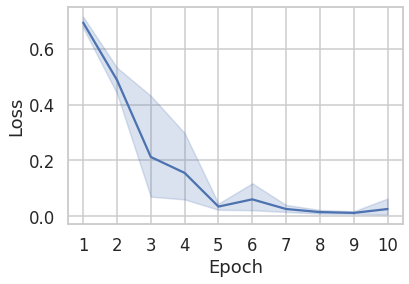

In [ ]:
g = sns.lineplot(
    data=epoch_loss_df, 
    x="Epoch", 
    y="Loss", 
    # errorbar=("sd", 1)
)

g.set_xticks([i+1 for i in range(10)])
g.set_xticklabels([i+1 for i in range(10)])
print()

In [ ]:
print("Mean F1 samples avg.:{:.0f} ± {:.2f}".format(100*np.mean(SCORES), 100*np.std(SCORES)))

Mean F1 samples avg.:89 ± 1.74


In [ ]:
DATAFRAMES

[              precision  recall  f1-score  support  Fold
 AN                 0.87    0.92      0.90       51     0
 AP                 0.82    0.98      0.89       85     0
 SD                 0.84    0.90      0.87       29     0
 CO                 0.95    0.88      0.92       43     0
 HA                 0.86    0.96      0.91       51     0
 micro avg          0.86    0.94      0.90      259     0
 macro avg          0.87    0.93      0.90      259     0
 weighted avg       0.86    0.94      0.90      259     0
 samples avg        0.90    0.95      0.91      259     0,
               precision  recall  f1-score  support  Fold
 AN                 0.78    0.89      0.83       36     1
 AP                 0.91    0.89      0.90       89     1
 SD                 0.84    0.87      0.85       30     1
 CO                 0.90    0.97      0.94       38     1
 HA                 0.92    0.86      0.89       56     1
 micro avg          0.88    0.89      0.89      249     1
 macro avg   

In [ ]:
pd.DataFrame(
    100*np.mean(np.array([d.values for d in DATAFRAMES]), axis=0),
    columns=DATAFRAMES[0].columns, 
    index=DATAFRAMES[0].index,
)[["precision", "recall","f1-score"]]

,precision,recall,f1-score
AN,81.8,91.6,86.4
AP,88.2,94.2,91.0
SD,78.2,87.4,82.0
CO,90.2,88.0,89.4
HA,86.8,88.4,87.6
micro avg,85.8,90.6,88.4
macro avg,85.0,89.8,87.2
weighted avg,86.0,90.6,88.4
samples avg,88.2,91.8,88.6


In [ ]:
pd.DataFrame(
    100*np.std(np.array([d.values for d in DATAFRAMES]), axis=0),
    columns=DATAFRAMES[0].columns, 
    index=DATAFRAMES[0].index,
)[["precision", "recall","f1-score"]]

,precision,recall,f1-score
AN,4.354308,3.720215,3.826225
AP,3.310589,3.867816,2.097618
SD,8.997778,2.727636,6.324555
CO,4.534314,5.477226,4.630335
HA,5.741080,4.270831,2.653300
micro avg,2.039608,2.154066,1.356466
macro avg,2.898275,1.939072,2.315167
weighted avg,1.788854,2.154066,1.356466
samples avg,1.600000,2.135416,1.743560


## Ablation Study<a id='ablation'></a>
To test the robustness of the model, we keep one collection just for testing

In [ ]:
# Defining model's specifications 
model_name        = "bert-large-cased"
max_length        = 512
device            = "cuda"
epochs            = 10
train_batch_size  = 2 # always use power of 2!
valid_batch_size  = 2
learning_rate     = 1e-05
froze_model_layer = False 
K_fold            = 5

# Tokenizer defined first to tokenize the inputs in the Dataset object
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=False)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [ ]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
cuda0 = torch.device('cuda:0')

Tesla T4
1


In [ ]:
SCORES, LOSSES, DATAFRAMES = [], [], []
for collection in set(final_df_dataset["collection"]):

    print('Test collection {}'.format(collection))
    train_loader, testing_loader = get_collection_Fold(collection)

    # makes sure the seed for model init is the same
    set_seed(seed, set_random=False) 
    
    # Set Model and Optmizer (for each fold)
    model_tuned = BERTClass(
        model_name=model_name, 
        n_classes=len(emotions_list), 
        freeze_BERT=False
    )

    optimizer_tuned = torch.optim.Adam(
    params=model_tuned.parameters(), 
    lr=learning_rate
    ) 
    
    model_tuned.to(cuda0)
    
    #Train and test the model
    for ep in range(epochs):
        train_losses = train(
            ep, 
            model_tuned, 
            train_loader, 
            optimizer_tuned, 
            return_losses=True,
        )
        LOSSES.append(train_losses)
    
    print("Testing the Model")
    outputs, targets = validation(model_tuned, testing_loader)
    outputs = np.array(outputs) >= 0.5    
    
    # send the model back to cpu and delete
    model_tuned.to("cpu")
    del model_tuned 
    
    # Compute and print results
    results_df = pd.DataFrame.from_dict(
        metrics.classification_report(
            targets,
            outputs,
            target_names=emotions_list,
            zero_division=0,
            output_dict=True,
        ), 
        orient='index',
    ).round(2)
    
    results_df["collection"] = [collection]*len(results_df)
    DATAFRAMES.append(results_df)
    
    f1_samp_av = results_df.at["samples avg", "f1-score"]
    print("F1 samples avg.: {}".format(f1_samp_av), end = "\n")
    SCORES.append(f1_samp_av)

Test collection Hall/VdC Norms: Male


Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max l

Epoch: 0, Loss:  0.6582982540130615
Epoch: 1, Loss:  0.43715736269950867
Epoch: 2, Loss:  0.16819341480731964
Epoch: 3, Loss:  0.049678172916173935
Epoch: 4, Loss:  0.009588176384568214
Epoch: 5, Loss:  0.06861413270235062
Epoch: 6, Loss:  0.021319417282938957
Epoch: 7, Loss:  0.03192146122455597
Epoch: 8, Loss:  0.01821022294461727
Epoch: 9, Loss:  0.016604384407401085
Testing the Model
F1 samples avg.: 0.87
Test collection Barb Sanders: baseline


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6274363994598389
Epoch: 1, Loss:  0.7439947128295898
Epoch: 2, Loss:  0.1747879832983017
Epoch: 3, Loss:  0.02172754518687725
Epoch: 4, Loss:  0.06780227273702621
Epoch: 5, Loss:  0.07266482710838318
Epoch: 6, Loss:  0.026404498144984245
Epoch: 7, Loss:  0.014214589260518551
Epoch: 8, Loss:  0.006526116281747818
Epoch: 9, Loss:  0.007945248857140541
Testing the Model
F1 samples avg.: 0.87
Test collection Hall/VdC Norms: Female


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.7349342703819275
Epoch: 1, Loss:  0.5110323429107666
Epoch: 2, Loss:  0.40583476424217224
Epoch: 3, Loss:  0.18740853667259216
Epoch: 4, Loss:  0.026530250906944275
Epoch: 5, Loss:  0.017199184745550156
Epoch: 6, Loss:  0.010191689245402813
Epoch: 7, Loss:  0.014471381902694702
Epoch: 8, Loss:  0.024818431586027145
Epoch: 9, Loss:  0.006206538062542677
Testing the Model
F1 samples avg.: 0.88
Test collection Ed: dreams of his late wife


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6402944922447205
Epoch: 1, Loss:  0.6088671088218689
Epoch: 2, Loss:  0.0989946573972702
Epoch: 3, Loss:  0.025031769648194313
Epoch: 4, Loss:  0.0671275332570076
Epoch: 5, Loss:  0.0883004292845726
Epoch: 6, Loss:  0.009188637137413025
Epoch: 7, Loss:  0.038736000657081604
Epoch: 8, Loss:  0.01884855329990387
Epoch: 9, Loss:  0.018723776564002037
Testing the Model
F1 samples avg.: 0.87
Test collection Emma: 48 years of dreams


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.7730568051338196
Epoch: 1, Loss:  0.6198098063468933
Epoch: 2, Loss:  0.2601642310619354
Epoch: 3, Loss:  0.03113446943461895
Epoch: 4, Loss:  0.022211486473679543
Epoch: 5, Loss:  0.013875185512006283
Epoch: 6, Loss:  0.01402533333748579
Epoch: 7, Loss:  0.05742797255516052
Epoch: 8, Loss:  0.009939243085682392
Epoch: 9, Loss:  0.009164165705442429
Testing the Model
F1 samples avg.: 0.89
Test collection Bea 1: a high school student


Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will 

Epoch: 0, Loss:  0.6390201449394226
Epoch: 1, Loss:  0.5898577570915222
Epoch: 2, Loss:  0.07461158186197281
Epoch: 3, Loss:  0.02775365673005581
Epoch: 4, Loss:  0.021926943212747574
Epoch: 5, Loss:  0.00953599251806736
Epoch: 6, Loss:  0.00865961890667677
Epoch: 7, Loss:  0.00784947071224451
Epoch: 8, Loss:  0.005984436254948378
Epoch: 9, Loss:  0.006054056342691183
Testing the Model
F1 samples avg.: 0.79


In [ ]:
DF_all = pd.concat(DATAFRAMES)
for clmn in ["precision","recall","f1-score"]:
  DF_all[clmn] = DF_all[clmn].apply(lambda x: 100*x)
DF_all

,precision,recall,f1-score,support,collection
AN,79.0,83.0,81.0,36,Hall/VdC Norms: Male
AP,84.0,97.0,90.0,86,Hall/VdC Norms: Male
SD,86.0,79.0,83.0,24,Hall/VdC Norms: Male
CO,94.0,83.0,88.0,58,Hall/VdC Norms: Male
HA,84.0,93.0,88.0,45,Hall/VdC Norms: Male
micro avg,85.0,89.0,87.0,249,Hall/VdC Norms: Male
macro avg,85.0,87.0,86.0,249,Hall/VdC Norms: Male
weighted avg,86.0,89.0,87.0,249,Hall/VdC Norms: Male
samples avg,87.0,89.0,87.0,249,Hall/VdC Norms: Male
AN,83.0,88.0,85.0,43,Barb Sanders: baseline


[Text(0, 0, 'Bea 1: a high school student'),
 Text(0, 0, 'Ed: dreams of his late wife'),
 Text(0, 0, 'Emma: 48 years of dreams'),
 Text(0, 0, 'Hall/VdC Norms: Female'),
 Text(0, 0, 'Hall/VdC Norms: Male'),
 Text(0, 0, 'Barb Sanders: baseline')]

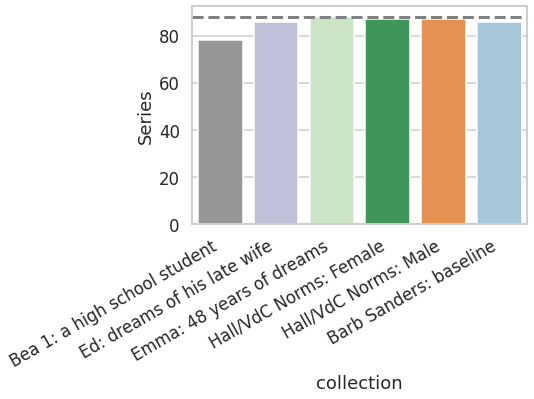

In [ ]:
g = sns.barplot(
    data=DF_all[["f1-score", "collection"]].loc["weighted avg"], 
    x="collection", 
    y="f1-score",
    palette="tab20c_r",
    order=COLLECTION_order,
)

g.set_ylabel("F1 Weighted average"), g.set_ylabel("Series")
g.axhline(88, ls='--', color="gray", linewidth=3)
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')

In [18]:
emot_acr = pd.DataFrame.from_dict({
    "Measure":["AN", "AP", "SD", "CO", "HA"],
    "f1-score":[86, 92, 82, 89, 87]
}
)

(Text(0, 0.5, 'F1 Weighted avg.'), Text(0.5, 0, ''))

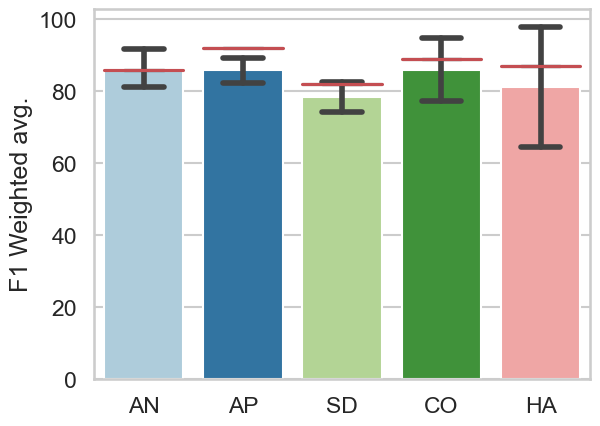

In [19]:
g = sns.barplot(
    data=DF_all[DF_all["Measure"].isin(["AN", "AP", "SD", "CO", "HA"])][["f1-score", "support", "Series", "Measure"]], 
    x="Measure",
    y="f1-score",
    palette="Paired",
    errorbar=("sd", 1),
    capsize=.4, 
    linewidth=1.5,
)

g = sns.boxplot(
    data=emot_acr, 
    x="Measure",
    y="f1-score",
    medianprops={"color": "r"}
)

g.set_ylabel("F1 Weighted avg."), g.set_xlabel("")

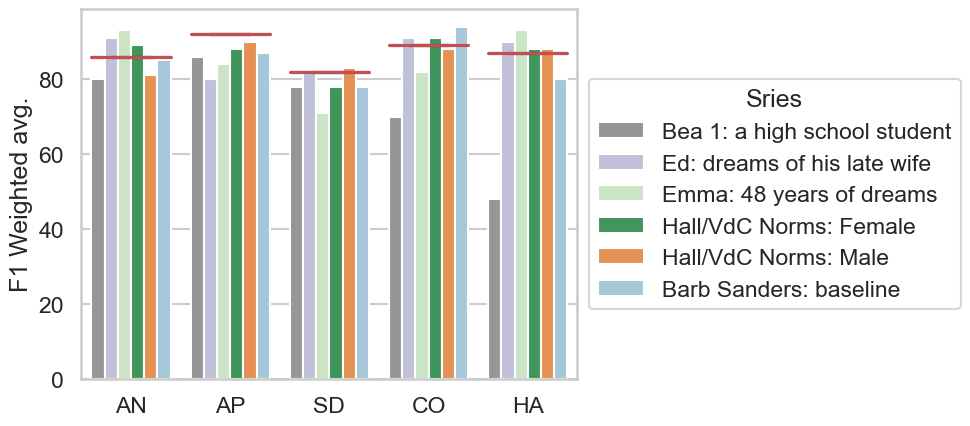

In [23]:
g = sns.barplot(
    data=DF_all[DF_all["Measure"].isin(["AN", "AP", "SD", "CO", "HA"])][["f1-score", "support", "Series", "Measure"]], 
    x="Measure",
    y="f1-score",
    hue="Series",
    hue_order=COLLECTION_order,
    palette="tab20c_r",
    errorbar=("sd", 1),
    capsize=.4, 
    linewidth=1.5,
)

g.set_ylabel("F1 Weighted avg."), 
g = sns.boxplot(
    data=emot_acr, 
    x="Measure",
    y="f1-score",
    medianprops={"color": "r"}
)

g.set_ylabel("F1 Weighted avg."), g.set_xlabel("")
g.legend(title="Sries",loc='center left', bbox_to_anchor=(1, 0.5))

Red lines indicatare the F1 value for the main experiment (i.e., the K-fold). Moreover, lets analyse of there is an impact of the support (i.e., the number of instances for each amotion) on the performance.

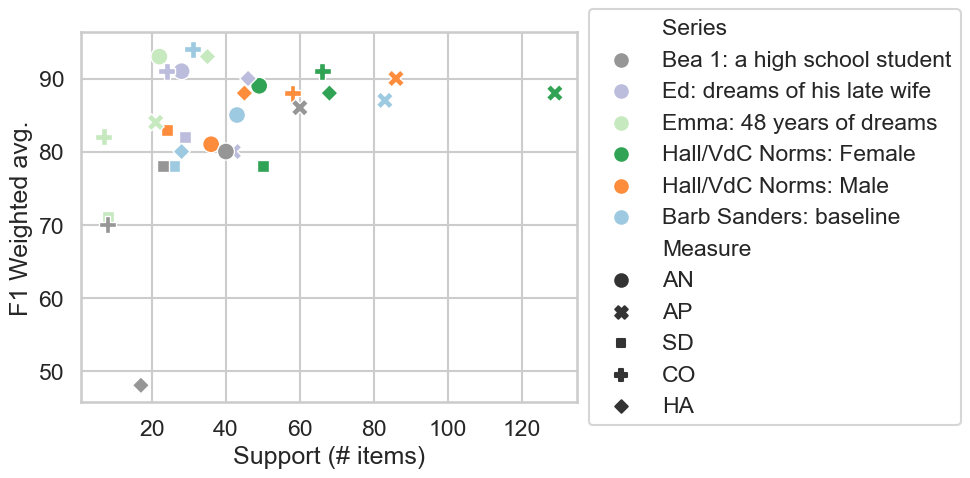

In [45]:
emot_acr = ["AP", "AN", "SD", "CO", "HA"]
    
g = sns.scatterplot(
    data=DF_all[DF_all["Measure"].isin(emot_acr)][["f1-score", "support", "Series", "Measure"]], 
    x="support", 
    y="f1-score",
    style="Measure",
    hue="Series",
    hue_order=COLLECTION_order,
    palette="tab20c_r",
    s=150,
)

# g.set(ylim=(68, 100), xlim=(15, 90))
g.set_ylabel("F1 Weighted avg."), g.set_xlabel("Support (# items)")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [31]:
spearmanr(
    DF_all[DF_all["Measure"].isin(emot_acr)]["support"], 
    DF_all[DF_all["Measure"].isin(emot_acr)]["f1-score"]
)

SpearmanrResult(correlation=0.3956718014173882, pvalue=0.03044151604270938)

In [50]:
for CLL in COLLECTION_order:
    lcl_df = DF_all[
                DF_all["Measure"].isin(emot_acr) & 
                DF_all["Series"].isin([CLL])
    ]
    rho, p = spearmanr(
        lcl_df["support"], 
        lcl_df["f1-score"]
    )
    print("{} rho: {:.2f}  p: {:.4f}".format(CLL, rho, p))

Bea 1: a high school student rho: 0.90  p: 0.0374
Ed: dreams of his late wife rho: -0.67  p: 0.2189
Emma: 48 years of dreams rho: 0.87  p: 0.0539
Hall/VdC Norms: Female rho: -0.15  p: 0.8048
Hall/VdC Norms: Male rho: 0.87  p: 0.0539
Barb Sanders: baseline rho: 0.70  p: 0.1881


Correlation are non or barely significant. This suggest there is something more complicated happeing. It is possible that, as earlier suggested (see paper), the overfitting is in fact with respect to specific relation betweeen emotions and collections, potetially even within single scorese. In other words, it seems that the model is quitee robust emotions, as far as those emotions are similarly expressed. 